## Chapter 2 – End-to-end Machine Learning project

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings 
import seaborn as sns

In [2]:
np.random.seed(42)
%matplotlib inline
mpl.rc('axes',labelsize = 14)
mpl.rc('xtick',labelsize = 20)
mpl.rc('ytick',labelsize = 20)
mpl.rc('axes',titlesize = 20)
warnings.filterwarnings(action='ignore')

In [3]:
sns.set_context('notebook')
sns.set_style('whitegrid')

### Function to save the plots

In [4]:
def save_fig(fig_id,tight_layout =True,fig_extension = 'png',resolution=300):
    path = os.path.join(fig_id,'.',fig_extension)
    print('Saving Figure :', fig_id)
    if tight_layout == True:
        plt.tight_layout()
    plt.savefig(fname = fig_id,format=fig_extension,dpi = resolution)

### Get the Data

In [5]:
housing = pd.read_csv('https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv')

In [6]:
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [7]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

In [8]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [9]:
housing.total_bedrooms.isna().sum()

207

In [10]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [11]:
housing.hist(bins = 50,figsize=(25,15))
save_fig("attributes_hist_plot")

Saving Figure : attributes_hist_plot


##### Notice a few things in these histograms:

* First, the median income attribute does not look like it is expressed in US dollars (USD). After checking with the team that collected the data, you are told that the data has been scaled and capped at 15 (actually 15.0001) for higher median incomes, and at 0.5 (actually 0.4999) for lower median incomes. The numbers represent roughly tens of thousands of dollars (e.g., 3 actually means about $30,000). Working with preprocessed attributes is common in Machine Learning, and it is not necessarily a problem, but you should try to understand how the data was computed.

* The housing median age and the median house value were also capped. The latter may be a serious problem since it is your target attribute (your labels). Your Machine Learning algorithms may learn that prices never go beyond that limit. You need to check with your client team (the team that will use your system’s output) to see if this is a problem or not. If they tell you that they need precise predictions even beyond $500,000, then you have two options:

    * Collect proper labels for the districts whose labels were capped.

    * Remove those districts from the training set (and also from the test set, since your system should not be evaluated poorly if it predicts values beyond $500,000).

* These attributes have very different scales. We will discuss this later in this chapter, when we explore feature scaling.

* Finally, many histograms are tail heavy: they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distributions.

### Creating a Test Train split 

In [12]:
def split_train_test(data,test_ratio):
    shuffle_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_incides = shuffle_indices[:test_set_size]
    train_indices = shuffle_indices[test_set_size:]
    print("The split was successful")
    return data.iloc[train_indices],data.iloc[test_incides]

In [13]:
train_set,test_set = split_train_test(housing,0.2)

The split was successful


In [14]:
len(train_set),len(test_set)

(16512, 4128)

In [15]:
from sklearn.model_selection import train_test_split

train_set,test_set = train_test_split(housing,test_size = 0.2 ,random_state = 42)

In [16]:
test_set.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
20046    -119.01     36.06                25.0       1505.0             NaN   
3024     -119.46     35.14                30.0       2943.0             NaN   
15663    -122.44     37.80                52.0       3830.0             NaN   
20484    -118.72     34.28                17.0       3051.0             NaN   
9814     -121.93     36.62                34.0       2351.0             NaN   

       population  households  median_income  median_house_value  \
20046      1392.0       359.0         1.6812             47700.0   
3024       1565.0       584.0         2.5313             45800.0   
15663      1310.0       963.0         3.4801            500001.0   
20484      1705.0       495.0         5.7376            218600.0   
9814       1063.0       428.0         3.7250            278000.0   

      ocean_proximity  
20046          INLAND  
3024           INLAND  
15663        NEAR BAY  
20484       <1H OCEAN  
9814       NEAR OCEAN

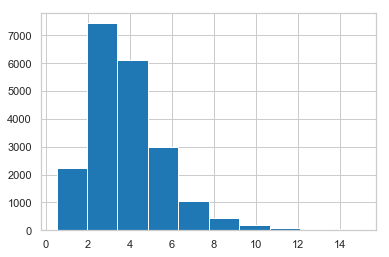

In [17]:
housing.median_income.hist()

In [18]:
housing['income_cat'] = pd.cut(housing.median_income,bins = [0.0,1.5,3.0,4.5,6.0,np.inf],labels=[1,2,3,4,5])

In [19]:
housing.income_cat.value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

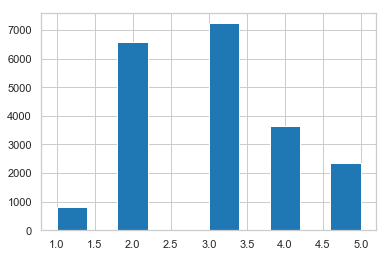

In [20]:
housing.income_cat.hist()

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1,test_size = 0.20,random_state = 42)
for train_index,test_index in split.split(housing,housing.income_cat):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

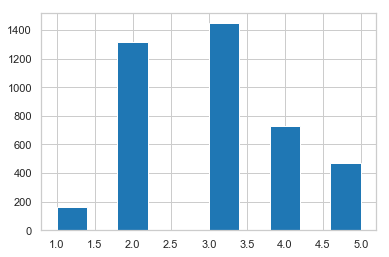

In [22]:
strat_test_set.income_cat.hist()

In [23]:
housing.income_cat.value_counts()/len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [24]:
strat_train_set.income_cat.value_counts()/len(strat_train_set)

3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_cat, dtype: float64

In [25]:
strat_test_set.income_cat.value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [26]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_prope = pd.DataFrame({
    'Overall': housing.income_cat.value_counts()/len(housing),
    'Stratified' : strat_test_set.income_cat.value_counts()/len(strat_test_set),
    'Random' : test_set.income_cat.value_counts()/len(test_set)
}).sort_index()

compare_prope["Rand. %error"] = 100 * compare_prope["Random"] / compare_prope["Overall"] - 100
compare_prope["Strat. %error"] = 100 * compare_prope["Stratified"] / compare_prope["Overall"] - 100

In [27]:
compare_prope

Overall  Stratified    Random  Rand. %error  Strat. %error
1  0.039826    0.039729  0.040213      0.973236      -0.243309
2  0.318847    0.318798  0.324370      1.732260      -0.015195
3  0.350581    0.350533  0.358527      2.266446      -0.013820
4  0.176308    0.176357  0.167393     -5.056334       0.027480
5  0.114438    0.114583  0.109496     -4.318374       0.127011

In [28]:
strat_test_set.drop('income_cat',axis=1,inplace=True)

In [29]:
strat_train_set.drop('income_cat',axis=1,inplace=True)

In [30]:
strat_train_set.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
17606    -121.89     37.29                38.0       1568.0           351.0   
18632    -121.93     37.05                14.0        679.0           108.0   
14650    -117.20     32.77                31.0       1952.0           471.0   
3230     -119.61     36.31                25.0       1847.0           371.0   
3555     -118.59     34.23                17.0       6592.0          1525.0   

       population  households  median_income  median_house_value  \
17606       710.0       339.0         2.7042            286600.0   
18632       306.0       113.0         6.4214            340600.0   
14650       936.0       462.0         2.8621            196900.0   
3230       1460.0       353.0         1.8839             46300.0   
3555       4459.0      1463.0         3.0347            254500.0   

      ocean_proximity  
17606       <1H OCEAN  
18632       <1H OCEAN  
14650      NEAR OCEAN  
3230           INLAND  
3555        <1H OCEAN

### Discover and Visualize the Data to Gain Insights

In [31]:
housing = strat_train_set.copy()

### Visualizing Geographical Data

In [32]:
plt.figure(figsize = (10,10))
plt.scatter(housing.longitude,housing.latitude,alpha=0.1)
plt.xlabel('longitude')
plt.ylabel('latitude')

Text(0,0.5,'latitude')

In [33]:
plt.figure(figsize = (10,10))
housing.plot(kind = 'scatter',x ='longitude',y ='latitude',alpha=0.1,figsize=(10,10),s = housing.population/100 ,label="population", c = 'median_house_value',cmap=plt.get_cmap('jet'),colorbar=True,
    sharex=False)
plt.legend()

<Figure size 720x720 with 0 Axes>

Saving Figure : california_housing_prices_plot


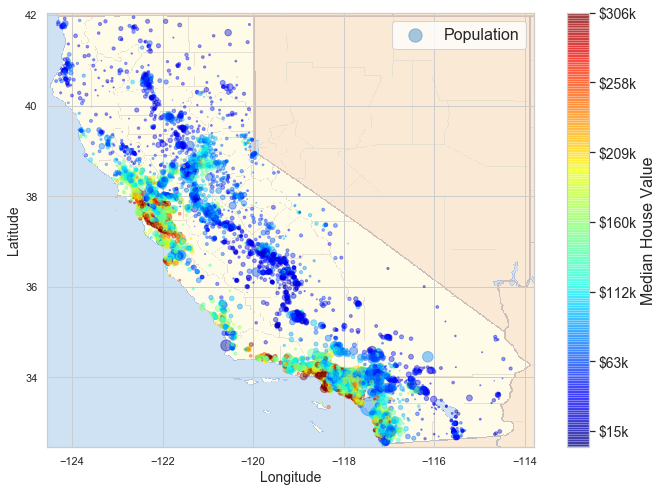

In [34]:
import matplotlib.image as mpimg
california_img = mpimg.imread('https://raw.githubusercontent.com/ageron/handson-ml2/master/images/end_to_end_project/california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5, cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

In [35]:
corr_matrix = housing.corr()

In [36]:
corr_matrix

longitude  latitude  housing_median_age  total_rooms  \
longitude            1.000000 -0.924478           -0.105848     0.048871   
latitude            -0.924478  1.000000            0.005766    -0.039184   
housing_median_age  -0.105848  0.005766            1.000000    -0.364509   
total_rooms          0.048871 -0.039184           -0.364509     1.000000   
total_bedrooms       0.076598 -0.072419           -0.325047     0.929379   
population           0.108030 -0.115222           -0.298710     0.855109   
households           0.063070 -0.077647           -0.306428     0.918392   
median_income       -0.019583 -0.075205           -0.111360     0.200087   
median_house_value  -0.047432 -0.142724            0.114110     0.135097   

                    total_bedrooms  population  households  median_income  \
longitude                 0.076598    0.108030    0.063070      -0.019583   
latitude                 -0.072419   -0.115222   -0.077647      -0.075205   
housing_median_age       -0.325047   -0.298710   -0.306428      -0.111360   
total_rooms               0.929379    0.855109    0.918392       0.200087   
total_bedrooms            1.000000    0.876320    0.980170      -0.009740   
population                0.876320    1.000000    0.904637       0.002380   
households                0.980170    0.904637    1.000000       0.010781   
median_income            -0.009740    0.002380    0.010781       1.000000   
median_house_value        0.047689   -0.026920    0.064506       0.687160   

                    median_house_value  
longitude                    -0.047432  
latitude                     -0.142724  
housing_median_age            0.114110  
total_rooms                   0.135097  
total_bedrooms                0.047689  
population                   -0.026920  
households                    0.064506  
median_income                 0.687160  
median_house_value            1.000000

In [37]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

<Figure size 864x576 with 0 Axes>

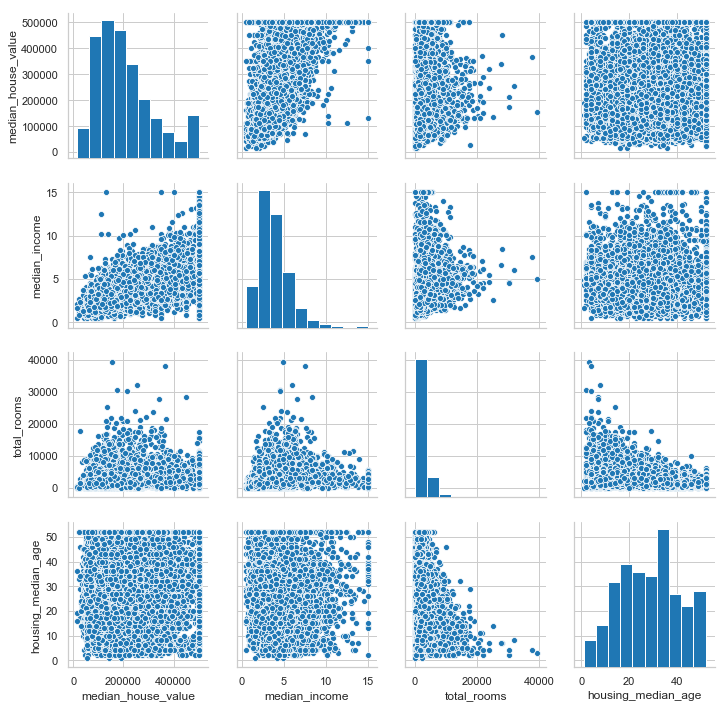

In [38]:
plt.figure(figsize=(12,8))
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
sns.pairplot(housing[attributes])

In [39]:
plt.scatter(housing['median_income'],housing['median_house_value'],alpha=0.2)

In [40]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [41]:

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

### Prepare the Data for Machine Learning Algorithms

In [42]:
housing = strat_train_set.drop('median_house_value',axis = 1)
housing_labels = strat_train_set['median_house_value'].copy()

In [43]:
sample_incomplete_rows = housing[housing.isnull().any(axis = 1)]

In [44]:
sample_incomplete_rows

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
4629     -118.30     34.07                18.0       3759.0             NaN   
6068     -117.86     34.01                16.0       4632.0             NaN   
17923    -121.97     37.35                30.0       1955.0             NaN   
13656    -117.30     34.05                 6.0       2155.0             NaN   
19252    -122.79     38.48                 7.0       6837.0             NaN   
20267    -119.19     34.20                18.0       3620.0             NaN   
1606     -122.08     37.88                26.0       2947.0             NaN   
4496     -118.22     34.05                34.0       1113.0             NaN   
16879    -122.39     37.60                34.0        707.0             NaN   
2412     -119.45     36.61                24.0       1302.0             NaN   
9622     -120.32     37.29                38.0        576.0             NaN   
6590     -118.18     34.19                48.0       1371.0             NaN   
15890    -122.38     37.73                40.0        543.0             NaN   
14641    -117.20     32.79                29.0       1213.0             NaN   
7168     -118.17     34.06                43.0        464.0             NaN   
9571     -120.61     37.36                16.0        638.0             NaN   
4279     -118.31     34.09                37.0        773.0             NaN   
5751     -118.27     34.17                52.0       2010.0             NaN   
19485    -120.98     37.66                10.0        934.0             NaN   
19060    -122.41     38.16                37.0       1549.0             NaN   
4591     -118.28     34.06                42.0       2472.0             NaN   
538      -122.28     37.78                29.0       5154.0             NaN   
5654     -118.30     33.73                42.0       1731.0             NaN   
15397    -117.20     33.24                12.0       4992.0             NaN   
9620     -120.40     37.30                28.0       1401.0             NaN   
20484    -118.72     34.28                17.0       3051.0             NaN   
19150    -122.70     38.35                14.0       2313.0             NaN   
2420     -119.44     36.58                37.0       1054.0             NaN   
9970     -122.48     38.50                37.0       3049.0             NaN   
17639    -121.90     37.28                26.0       3756.0             NaN   
...          ...       ...                 ...          ...             ...   
16757    -122.48     37.70                33.0       4492.0             NaN   
19932    -119.33     36.30                11.0       3045.0             NaN   
4743     -118.36     34.05                42.0       1372.0             NaN   
18177    -122.00     37.36                17.0       2070.0             NaN   
6835     -118.12     34.08                35.0       2248.0             NaN   
5236     -118.23     33.94                36.0       1110.0             NaN   
6962     -118.05     33.99                38.0       1619.0             NaN   
12570    -121.44     38.54                39.0       2855.0             NaN   
15607    -116.66     32.79                13.0        843.0             NaN   
19559    -120.98     37.60                36.0       1437.0             NaN   
7113     -118.02     33.89                36.0       1375.0             NaN   
14173    -117.05     32.75                36.0       2024.0             NaN   
11741    -121.13     38.87                48.0       1127.0             NaN   
13933    -117.31     34.25                29.0       4610.0             NaN   
15137    -116.91     32.83                16.0       5203.0             NaN   
15118    -116.95     32.84                31.0       1307.0             NaN   
16025    -122.44     37.73                39.0       1912.0             NaN   
17928    -121.97     37.34                33.0       3162.0             NaN   
5678     -118.30     33.72                35.0       2790

In [45]:
median = housing['total_bedrooms'].median()
housing.total_bedrooms.fillna(median,inplace=True)

### Handling Text and Categorical Attributes

In [51]:
housing_cat = housing[['ocean_proximity']]

In [52]:
housing_cat.head()

ocean_proximity
17606       <1H OCEAN
18632       <1H OCEAN
14650      NEAR OCEAN
3230           INLAND
3555        <1H OCEAN

In [53]:
from sklearn.preprocessing import OrdinalEncoder

In [54]:
ordinal_encorder = OrdinalEncoder()
housing_cat_encoded = ordinal_encorder.fit_transform(housing_cat)

In [56]:
ordinal_encorder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [57]:
from sklearn.preprocessing import OneHotEncoder

In [59]:
cat_encorder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encorder.fit_transform(housing_cat)

In [60]:
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [61]:
cat_encorder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [62]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [63]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

longitude latitude housing_median_age total_rooms total_bedrooms  \
17606   -121.89    37.29                 38        1568            351   
18632   -121.93    37.05                 14         679            108   
14650    -117.2    32.77                 31        1952            471   
3230    -119.61    36.31                 25        1847            371   
3555    -118.59    34.23                 17        6592           1525   

      population households median_income ocean_proximity rooms_per_household  \
17606        710        339        2.7042       <1H OCEAN             4.62537   
18632        306        113        6.4214       <1H OCEAN             6.00885   
14650        936        462        2.8621      NEAR OCEAN             4.22511   
3230        1460        353        1.8839          INLAND             5.23229   
3555        4459       1463        3.0347       <1H OCEAN             4.50581   

      population_per_household  
17606                   2.0944  
18632                  2.70796  
14650                  2.02597  
3230                   4.13598  
3555                   3.04785

In [77]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)

Empty DataFrame
Columns: [longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income]
Index: []

In [78]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

In [79]:
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [70]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [71]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

### Select and Train a Model

In [82]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [83]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [84]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [85]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

In [86]:

from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.89599001897

In [87]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [88]:

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

### Fine-tune your model

In [89]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [90]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
Mean: 71407.68766037929
Standard deviation: 2439.4345041191004


In [91]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)


Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798346


In [92]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [93]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18603.515021376355

In [94]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [49519.80364233 47461.9115823  50029.02762854 52325.28068953
 49308.39426421 53446.37892622 48634.8036574  47585.73832311
 53490.10699751 50021.5852922 ]
Mean: 50182.303100336096
Standard deviation: 2097.0810550985693


In [95]:

scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69052.461363
std       2879.437224
min      64969.630564
25%      67136.363758
50%      68156.372635
75%      70982.369487
max      74739.570526
dtype: float64

In [96]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111094.6308539982

In [97]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],


In [98]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [100]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [101]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64911.376987917916 {'max_features': 2, 'n_estimators': 3}
55588.601420527455 {'max_features': 2, 'n_estimators': 10}
53148.91358803413 {'max_features': 2, 'n_estimators': 30}
60980.098380042204 {'max_features': 4, 'n_estimators': 3}
52783.26102285533 {'max_features': 4, 'n_estimators': 10}
50371.90263495316 {'max_features': 4, 'n_estimators': 30}
58825.566353938964 {'max_features': 6, 'n_estimators': 3}
52097.06610553582 {'max_features': 6, 'n_estimators': 10}
49947.73431526056 {'max_features': 6, 'n_estimators': 30}
58455.959922126836 {'max_features': 8, 'n_estimators': 3}
52362.516738840495 {'max_features': 8, 'n_estimators': 10}
50060.53084613547 {'max_features': 8, 'n_estimators': 30}
62573.92183787568 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54271.123465350014 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60157.9680418247 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52847.6505472896 {'bootstrap': False, 'max_features': 3, 'n_estimators

In [102]:
pd.DataFrame(grid_search.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.054659      0.003628         0.003185        0.000954   
1        0.169953      0.003010         0.007380        0.000489   
2        0.516993      0.014493         0.022563        0.002423   
3        0.079986      0.001716         0.002593        0.000488   
4        0.267285      0.002957         0.007580        0.000489   
5        0.800063      0.005829         0.020544        0.000490   
6        0.110504      0.001716         0.002195        0.000398   
7        0.365425      0.003126         0.007578        0.000798   
8        1.099857      0.008401         0.020749        0.000401   
9        0.145213      0.003136         0.002588        0.000484   
10       0.467953      0.005998         0.007180        0.000399   
11       1.430778      0.051941         0.021142        0.001161   
12       0.083175      0.001353         0.002993        0.000005   
13       0.277658      0.006008         0.009576        0.001738   
14       0.108497      0.001841         0.003398        0.000484   
15       0.355849      0.003592         0.008977        0.000893   
16       0.135626      0.001799         0.003196        0.000414   
17       0.431053      0.009133         0.008978        0.001266   

   param_max_features param_n_estimators param_bootstrap  \
0                   2                  3             NaN   
1                   2                 10             NaN   
2                   2                 30             NaN   
3                   4                  3             NaN   
4                   4                 10             NaN   
5                   4                 30             NaN   
6                   6                  3             NaN   
7                   6                 10             NaN   
8                   6                 30             NaN   
9                   8                  3             NaN   
10                  8                 10             NaN   
11                  8                 30             NaN   
12                  2                  3           False   
13                  2                 10           False   
14                  3                  3           False   
15                  3                 10           False   
16                  4                  3           False   
17                  4                 10           False   

                                               params  split0_test_score  \
0              {'max_features': 2, 'n_estimators': 3}      -4.183599e+09   
1             {'max_features': 2, 'n_estimators': 10}      -2.946292e+09   
2             {'max_features': 2, 'n_estimators': 30}      -2.691191e+09   
3              {'max_features': 4, 'n_estimators': 3}      -3.478702e+09   
4             {'max_features': 4, 'n_estimators': 10}      -2.688014e+09   
5             {'max_features': 4, 'n_estimators': 30}      -2.384079e+09   
6              {'max_features': 6, 'n_estimators': 3}      -3.290895e+09   
7             {'max_features': 6, 'n_estimators': 10}      -2.527354e+09   
8             {'max_features': 6, 'n_estimators': 30}      -2.322282e+09   
9              {'max_features': 8, 'n_estimators': 3}      -3.314138e+09   
10            {'max_features': 8, 'n_estimators': 10}      -2.655986e+09   
11            {'max_features': 8, 'n_estimators': 30}      -2.374325e+09   
12  {'bootstrap': False, 'max_features': 2, 'n_est...      -3.708598e+09   
13  {'bootstrap': False, 'max_features': 2, 'n_est...      -2.718622e+09   
14  {'bootstrap': False, 'max_features': 3, 'n_est...      -3.566104e+09   
15  {'bootstrap': False, 'max_features': 3, 'n_est...      -2.724813e+09   
16  {'bootstrap': False, 'max_features': 4, 'n_est...      -3.135801e+09   
17  {'bootstrap': False, 'max_features': 4, 'n_est...      -2.456778e+09   

    split1_test_score       ...         mean_test_score  std_test_score  \
0       -4.113517e+09       ...           -4.21348

In [103]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [104]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49150.657232934034 {'max_features': 7, 'n_estimators': 180}
51389.85295710133 {'max_features': 5, 'n_estimators': 15}
50796.12045980556 {'max_features': 3, 'n_estimators': 72}
50835.09932039744 {'max_features': 5, 'n_estimators': 21}
49280.90117886215 {'max_features': 7, 'n_estimators': 122}
50774.86679035961 {'max_features': 3, 'n_estimators': 75}
50682.75001237282 {'max_features': 3, 'n_estimators': 88}
49608.94061293652 {'max_features': 5, 'n_estimators': 100}
50473.57642831875 {'max_features': 3, 'n_estimators': 150}
64429.763804893395 {'max_features': 5, 'n_estimators': 2}


In [105]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.39457162e-02, 7.04071838e-02, 4.27699146e-02, 1.74125072e-02,
       1.78120534e-02, 1.80387371e-02, 1.65766826e-02, 3.03863580e-01,
       5.72863188e-02, 1.09741158e-01, 1.03478746e-01, 9.20830792e-03,
       1.52083551e-01, 7.48682265e-05, 2.30026889e-03, 5.00040597e-03])

In [106]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.30386358028050536, 'median_income'),
 (0.1520835511744197, 'INLAND'),
 (0.10974115787428117, 'pop_per_hhold'),
 (0.10347874592991775, 'bedrooms_per_room'),
 (0.0739457162480078, 'longitude'),
 (0.07040718381674661, 'latitude'),
 (0.057286318751791465, 'rooms_per_hhold'),
 (0.04276991464294279, 'housing_median_age'),
 (0.018038737053918227, 'population'),
 (0.017812053448574946, 'total_bedrooms'),
 (0.017412507150405886, 'total_rooms'),
 (0.016576682613226663, 'households'),
 (0.009208307923657882, '<1H OCEAN'),
 (0.005000405974278103, 'NEAR OCEAN'),
 (0.0023002688908569002, 'NEAR BAY'),
 (7.486822646874753e-05, 'ISLAND')]

### Evaluate Your System on the Test Set

In [107]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [108]:
final_rmse

48363.35902684103

In [109]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([46385.5459965 , 50263.40731909])

In [110]:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(46385.54599649723, 50263.40731909308)

In [111]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(46386.13840815973, 50262.86060599087)